In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
from PIL import Image
import cv2
import imageio
import random

In [2]:
X,Y = [], []
path, direc, docs = next(os.walk("./orl_faces"))
direc.sort()
# Iterating through each subject
for subject in direc:
    files = os.listdir(path+'/'+subject)
    for file in files:
        img = np.array(imageio.imread(path+'/'+subject+'/'+file).astype(np.float32))      
        img = cv2.resize(img, dsize=(56, 46)).astype(np.float32)
        X.append(img.reshape(-1))
        Y.append(int(subject[1:]))
X = np.array(X)
Y = np.array(Y)

In [3]:
import sklearn
from sklearn.model_selection import KFold

In [4]:
X,Y = sklearn.utils.shuffle(X,Y)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.5)

In [7]:
mean_image = np.mean(X, axis=0)

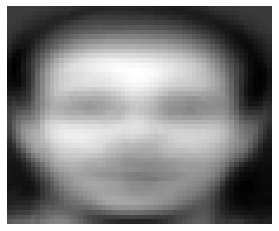

In [8]:
plt.imshow(mean_image.reshape(46,56),cmap="gray")
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off')
plt.axis('off')
plt.savefig('mean.png')
plt.show()

In [9]:
kPCA= 100
X_train -= np.mean(X_train, axis=0)
X_test -= np.mean(X_test, axis=0)
CovMatrix = np.cov(X_train.T)
eigenValues, eigenVectors = np.linalg.eigh(CovMatrix)
acceptedIndex = np.argsort(eigenValues)[::-1][:kPCA]
eigenVectors = eigenVectors[:, acceptedIndex]
eigenValues = eigenValues[acceptedIndex]

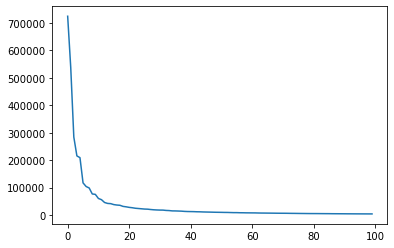

In [10]:
plt.plot(eigenValues)
plt.savefig('EigenGraph.png')
plt.show()

In [11]:
import matplotlib.gridspec as gridspec

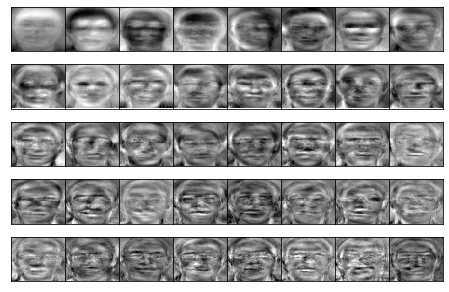

<Figure size 432x288 with 0 Axes>

In [12]:
gs = gridspec.GridSpec(5, 8, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   
i = 0
for g in gs:
    temp_display = (eigenVectors.T[i]).reshape(46,56)
#     plt.subplot(5,8,1+i)
#     plt.imshow(temp_display,cmap="gray")
#     plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off')
#     plt.axis('off')
    
    ax = plt.subplot(g)
    ax.imshow(temp_display, cmap = plt.get_cmap("gray"))
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1
plt.savefig('Top40Eigen.png')
plt.show()
plt.clf()
del temp_display

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [14]:
def PCA_SVM(kPCA,X,Y):
    PCAWithSVC = []
    noOfFolds = 5
    K_Folds = KFold(n_splits = noOfFolds)
    for train, test in K_Folds.split(X):
        X_train, X_test, Y_train, Y_test = X[train], X[test], Y[train], Y[test]
    #   Lets Implement PCA 
#         print( np.mean(X_train, axis=0))
        X_train -= np.mean(X_train, axis=0)
        X_test -= np.mean(X_test, axis=0)
        CovMatrix = np.cov(X_train.T)
        eigenValues, eigenVectors = np.linalg.eigh(CovMatrix)
        acceptedIndex = np.argsort(eigenValues)[::-1][:kPCA]
        eigenVectors = eigenVectors[:, acceptedIndex]
        eigenValues = eigenValues[acceptedIndex]
        
        xTrainPCA = np.dot(eigenVectors.T, X_train.T).T
        xTestPCA = np.dot(eigenVectors.T, X_test.T).T
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(xTrainPCA, Y_train)
        
        y_predSVC = svclassifier.predict(xTestPCA)
        PCAWithSVC.append(np.mean(y_predSVC == Y_test))
        
#         print(PCAWithSVC)
    return(np.mean(PCAWithSVC))
#     return PCAWithSVC

In [15]:
def PCA_KNN(kPCA,neighbors, X,Y):
    PCAWithKNN = []
    noOfFolds = 5
    K_Folds = KFold(n_splits = noOfFolds)
    for train, test in K_Folds.split(X):
        X_train, X_test, Y_train, Y_test = X[train], X[test], Y[train], Y[test]

    #   Lets Implement PCA 

        X_train -= np.mean(X_train, axis=0)
        X_test -= np.mean(X_test, axis=0)

        CovMatrix = np.cov(X_train.T)
        eigenValues, eigenVectors = np.linalg.eigh(CovMatrix)
        acceptedIndex = np.argsort(eigenValues)[::-1][:kPCA]
        eigenVectors = eigenVectors[:, acceptedIndex]

        eigenValues = eigenValues[acceptedIndex]
    #     plt.plot(eigenValues)
    #     plt.show()

        xTrainPCA = np.dot(eigenVectors.T, X_train.T).T
        xTestPCA = np.dot(eigenVectors.T, X_test.T).T

    #   KNN considering K as 1
        classifier = KNeighborsClassifier(n_neighbors=neighbors)
        classifier.fit(xTrainPCA, Y_train)
        y_predKNN = classifier.predict(xTestPCA)
        PCAWithKNN.append(np.mean(y_predKNN == Y_test))
#         print(Y_test.head())
#     r = random.randint(0, len(X_test)-1)
#     print("Lets Try a test Image")
#     plt.imshow(X_test[r].reshape(46, 56), cmap = plt.get_cmap("gray"))
#     plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off')
#     plt.axis('off')
#     plt.show()
#     plt.clf()
#     print("Face recognized is of subject "+str(int(y_predKNN[r]+1)).zfill(2))
    return np.mean(PCAWithKNN)


In [16]:
kPCA  = [10,30,40,60,70]
accuracy_SVM = {} 
for k in kPCA:
    accuracy_SVM[k] = PCA_SVM(k,X,Y)
#Best K for PCA with SVM Classification is
bestK = -1
maxAcc = -1
for i,j in accuracy_SVM.items():
    if j>maxAcc:
        maxAcc = j
        bestK = i
print("Best K for PCA with SVM Classification of Eigen Faces is "+str(bestK)+" with "+str(round(maxAcc,4)*100)+" %")

Best K for PCA with SVM Classification of Eigen Faces is 30 with 96.75 %


In [18]:
kPCA  = [10,30,40,60,70]
neighbors = [1,3,5,7]
accuracy_KNN = {} 
for k in kPCA:
    accuracy_KNN[k] = PCA_KNN(k,neighbors[0],X,Y)
#Best K for PCA with KNN Classification is
bestK = -1
maxAcc = -1
for i,j in accuracy_KNN.items():
    if j>maxAcc:
        maxAcc = j
        bestK = i
print("Best K for PCA with KNN Classification of Eigen Faces is "+str(bestK)+" with "+str(round(maxAcc,4)*100)+" %")

Best K for PCA with KNN Classification of Eigen Faces is 60 with 96.0 %
